# Projeto Final da Disciplina Mineração de Textos e Web Ministrada pelo Prof. Luciano Barbosa

**Equipe:**
<br>David Soares do Monte
<br>Wanderson Rodrigues Marques


# Etapa 1: Dataset

## Informações sobre o dataset
O dataset é composto por 5000 avaliações obtidas no site da Amazon Brasil referentes ao produto "Suporte para Notebook, OCTOO, Uptable, UP-BL, Preto" (https://www.amazon.com.br/OCTOO-UP-BL-Suporte-Uptable-Preto/dp/B07BTC67VS/ref=zg-bs_furniture_1/144-8354270-3806822).

## Importação das Bibliotecas Necessárias

In [29]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sn
import math
import os
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

## Instalação de bibliotecas

In [30]:
!pip install transformers
from transformers import AdamW, BertForSequenceClassification, BertTokenizer, DataCollatorWithPadding

In [31]:
# from google.colab import drive
# drive.mount('/content/drive')

## Importação e Pré-processamento do Dataset

In [32]:
# Importa o dataset

df = pd.read_csv('../Datasets/fake_reviews_dataset.csv')


In [33]:
# Imprime 5 amostras do dataset

df.sample(5)

,category,rating,label,text_
21702,Pet_Supplies_5,5.0,OR,It's among the top three favorites for the dog...
25586,Kindle_Store_5,3.0,OR,It ended very abruptly. I was really enjoying ...
2365,Home_and_Kitchen_5,3.0,OR,This puts out very little oil. It's hard to te...
27275,Kindle_Store_5,5.0,CG,I started anticipating Felan's story and it ke...
76,Home_and_Kitchen_5,5.0,OR,"Smells great, and the fine mist dries quickly...."


In [34]:
df = df[0:4000]

In [35]:
# Imprime formato do dataset

print('Shape do dataset:', df.shape)

Shape do dataset: (4000, 4)


In [36]:
df_reviews = df[["text_","label"]]

In [37]:
# Verificação de dados ausentes
(df_reviews.isna().sum())

text_    0
label    0
dtype: int64

In [38]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text_   4000 non-null   object
 1   label   4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


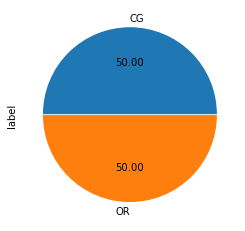

In [39]:
# Verificação do balaceamento das classes - coluna 'sentiment'
df_reviews['label'].value_counts().plot.pie(autopct='%.2f', explode=[0.01, 0]);

Os dados estão desbalanceados

# Etapa 2: Processamento dos Dados Textuais

## Fazendo Split nos dados

In [40]:
seed = 1275

train_dev, test = train_test_split(df_reviews, test_size=0.1, random_state=seed, stratify=df_reviews['label'])
train, dev = train_test_split(train_dev, test_size=0.2, random_state=seed, stratify=train_dev['label'])

print('Tamanho de treino:', train.shape[0])
print('Tamanho de validação:', dev.shape[0])
print('Tamanho de teste:', test.shape[0])

Tamanho de treino: 2880
Tamanho de validação: 720
Tamanho de teste: 400


Convertendo a classe para numérico

In [41]:
y_test = test['label'].apply(lambda x: 1 if x == 'OR' else 0)

## C4: BERT
Classe criada para tokenizar os exemplos e fornecer os pares de inputs e labels para o modelo

In [42]:
class defClass(Dataset):  
    def __init__(self, tokenizer, X, y):
        X = list(X)
        y = list(y)
        tokenized_data = tokenizer(X, truncation=True, max_length=512)
        samples = [
            {
                **{key: tokenized_data[key][i] for key in tokenized_data},
                'labels': y[i]
            }
             
            for i in range(len(X))
        ]
        self.samples = samples
    
    def __getitem__(self, i):
        return self.samples[i]
    
    def __len__(self):
        return len(self.samples)

### Função auxiliar

Enviando as entradas para o device

In [43]:
def send_inputs_to_device(inputs, device):
    return {key:tensor.to(device) for key, tensor in inputs.items()}

## Preparando os dados (Tokenização)

Treino, validação e teste

In [44]:
from transformers import BertTokenizer, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
train_dataset = defClass(tokenizer, train['text_'], (train['label'] == 'OR').astype(int))
dev_dataset   = defClass(tokenizer, dev['text_'], (dev['label'] == 'OR').astype(int))
test_dataset  = defClass(tokenizer, test['text_'], (test['label'] == 'OR').astype(int))

In [45]:
len(tokenizer.vocab)

29794

Aqui, nós vamos utilizar o DataCollatorWithPadding. Uma vez que os nossos exemplos podem ter comprimentos diferentes, precisamos colocar padding para juntá-los em um batch. O DataCollatorWithPadding já faz isso para nós.

In [46]:
train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=DataCollatorWithPadding(tokenizer))
dev_loader = DataLoader(dev_dataset, batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))

### Implementação o modelo e otimizador - PT-BR
Aqui nós definimos uma coisa extra que é começar o modelo com a parte pré treinada do BERT congelada. Assim a gente permite aos pesos do layer de classificação se acomodarem antes de começar a fazer o fine-tune na rede toda.

In [47]:
from transformers import logging
logging.set_verbosity_error()
model = BertForSequenceClassification.from_pretrained(
    'ProsusAI/finbert')
model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6) # Alterei o otimizador
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9997)


for param in model.base_model.parameters():
    param.requires_grad = False

## Treinando o modelo
Aqui vamos fazer a avaliação no devset a cada 200 passos. No passo 800 vamos soltar os pesos do modelo base do BERT pra aprender.

In [48]:
def evaluate(model, dev_loader, device):
    with torch.no_grad():
        model.eval()
        dev_losses = []
        tp, tn, fp, fn = [], [], [], []
        for inputs in dev_loader:
            inputs = send_inputs_to_device(inputs, device)
            loss, scores = model(**inputs)[:2]
            dev_losses.append(loss.cpu().item())

            _, classification = torch.max(scores, 1)
            labels = inputs['labels']
            tp.append(((classification==1) & (labels==1)).sum().cpu().item())
            tn.append(((classification==0) & (labels==0)).sum().cpu().item())
            fp.append(((classification==1) & (labels==0)).sum().cpu().item())
            fn.append(((classification==0) & (labels==1)).sum().cpu().item())

        tp_s, tn_s, fp_s, fn_s = sum(tp), sum(tn), sum(fp), sum(fn)
        print('Dev loss: {:.2f}; Acc: {:.2f}; tp: {}; tn: {}; fp: {}; fn: {}'.format( 
              np.mean(dev_losses), (tp_s+tn_s)/(tp_s+tn_s+fp_s+fn_s), tp_s, tn_s, fp_s, fn_s))

        model.train()

In [49]:
epoch_bar = tqdm_notebook(range(3))
loss_acc = 0
alpha = 0.95
for epoch in epoch_bar:
    batch_bar = tqdm_notebook(enumerate(train_loader), desc=f'Época {epoch}', total=len(train_loader))
    for idx, inputs in batch_bar:
        if (epoch * len(train_loader) + idx) == 800:
            for param in model.base_model.parameters():
                param.requires_grad = True

        inputs = send_inputs_to_device(inputs, device)
        optimizer.zero_grad()
        loss, logits = model(**inputs)[:2]
        
        loss.backward()
        optimizer.step()
        if epoch == 0 and idx == 0:
            loss_acc = loss.cpu().item()
        else:
            loss_acc = loss_acc * alpha + (1-alpha) * loss.cpu().item()
        batch_bar.set_postfix(loss=loss_acc)
        if idx%200 == 0:
            del inputs
            del loss
            evaluate(model, dev_loader, device)

        scheduler.step()
     

  0%|          | 0/3 [00:00<?, ?it/s]

Época 0:   0%|          | 0/360 [00:00<?, ?it/s]

Dev loss: 2.60; Acc: 1.00; tp: 0; tn: 1; fp: 0; fn: 0
Dev loss: 2.09; Acc: 1.00; tp: 0; tn: 1; fp: 0; fn: 0


Época 1:   0%|          | 0/360 [00:00<?, ?it/s]

Dev loss: 1.78; Acc: 1.00; tp: 3; tn: 3; fp: 0; fn: 0
Dev loss: 1.49; Acc: 0.79; tp: 9; tn: 13; fp: 0; fn: 6


Época 2:   0%|          | 0/360 [00:00<?, ?it/s]

Dev loss: 1.33; Acc: 0.54; tp: 20; tn: 43; fp: 17; fn: 36


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 1.96 GiB total capacity; 1.29 GiB already allocated; 54.25 MiB free; 1.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Validando o modelo
Agora vamos verificar o desempenho no dev set. Vamos ver a curva ROC e tb qual o melhor threshold de classificação com respeito a nossa métrica escolhida, acurácia

In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    labels = []
    for inputs in tqdm_notebook(dev_loader):
        inputs = send_inputs_to_device(inputs, device)
        _, scores = model(**inputs)[:2]
        pred.append(F.softmax(scores, dim=1)[:, 1].cpu())
        labels.append(inputs['labels'].cpu())
pred = torch.cat(pred).numpy()
labels = torch.cat(labels).numpy()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(labels, pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

fig = px.scatter(
    x=fpr, y=tpr, color=thresholds, 
    labels={'x': 'Falso positivo rate', 'y': 'Verdadeiro positivo rate'},
    title='Curva ROC')
fig.show()

In [ ]:
acc = []
for th in thresholds:
    acc.append(metrics.accuracy_score(pred > th, labels))

fig2 = px.scatter(
    x=thresholds, y=acc, labels={'x': 'threshold', 'y': 'acurácia'}, 
    title='Acurácia em diferentes thresholds')
fig2.show() 

## Avaliação final
Finalmente vamos avaliar o modelo no conjunto de test com o threshold escolhido

In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    labels = []
    for inputs in tqdm_notebook(test_loader):
        inputs = send_inputs_to_device(inputs, device)
        _, scores = model(**inputs)[:2]
        pred.append(F.softmax(scores, dim=1)[:, 1].cpu())
        labels.append(inputs['labels'].cpu())
pred = torch.cat(pred).numpy()
labels = torch.cat(labels).numpy()

In [ ]:
y_pred = [1 if x > 0.5 else 0 for x in pred]

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("\nClasification report:\n", classification_report(y_test, y_pred))

In [ ]:
# Matriz de confusão com heatmap
cnn_confusion_matrix = pd.crosstab(np.reshape(y_test, len(y_pred)), np.reshape(y_pred, len(y_pred)), rownames=['Valor Atual'], colnames=['Valor Predito'])

sn.heatmap(cnn_confusion_matrix, annot=True, fmt="d", cmap='inferno', linewidths=.5)
plt.show()